In [41]:
import pandas as pd
import numpy as np

In [42]:
pd.set_option('display.max_columns', None)

In [43]:
df = pd.read_csv(r"C:\Users\mabin\Desktop\DataScienceClassNotes\Career247_Capstone_Project\Fraud_Detection_Project\data\raw\cleaned_data_v1.csv")

In [44]:
df.shape

(50000, 26)

In [45]:
df.head()

,transaction_id,customer_id,device_id,merchant_id,transaction_date,transaction_time,amount,payment_method,is_international,merchant_category,ip_address_risk_score,device_trust_score,txn_count_last_24h,avg_amount_last_24h,merchant_diversity_last_7d,device_change_flag,location_change_flag,authentication_method,otp_success_rate_customer,past_fraud_count_customer,past_disputes_customer,merchant_historical_fraud_rate,hour_of_day,day_of_week,is_weekend,is_fraud
0,1,1357,20937,720,2024-01-18,19:23:00,18780.52,WALLET,0,Travel,0.243550,0.116606,7,6055.25,3,0,0,NONE,0.769328,1,2,0.069502,19,3,0,0
1,2,4095,29542,764,2024-03-30,02:22:00,18955.06,CARD,0,Electronics,0.119761,0.030579,1,13366.74,5,0,1,OTP,0.468411,1,1,0.010010,2,5,1,0
2,3,3618,25236,671,2024-01-04,17:26:00,10743.34,UPI,0,Fashion,0.565367,0.183770,0,7359.14,4,0,0,PIN,0.464356,0,1,0.118434,17,3,0,0
3,4,2755,29904,624,2024-01-27,16:00:00,5054.75,CARD,0,Utilities,0.843842,0.717286,5,10923.57,6,0,0,PIN,0.635799,0,3,0.114947,16,5,1,0
4,5,2732,24151,501,2024-02-20,23:14:00,14799.50,CARD,0,Gaming,0.202402,0.041616,11,6027.72,10,1,0,OTP,0.684301,2,0,0.014550,23,1,0,0


In [46]:
df.duplicated().sum()

np.int64(0)

In [47]:
df.nunique(dropna=False)

transaction_id                    50000
customer_id                        4000
device_id                          9946
merchant_id                         300
transaction_date                     90
transaction_time                   1440
amount                            49412
payment_method                        4
is_international                      2
merchant_category                     6
ip_address_risk_score             50000
device_trust_score                50000
txn_count_last_24h                   12
avg_amount_last_24h               49167
merchant_diversity_last_7d           11
device_change_flag                    2
location_change_flag                  2
authentication_method                 4
otp_success_rate_customer         50000
past_fraud_count_customer             3
past_disputes_customer                5
merchant_historical_fraud_rate    49994
hour_of_day                          24
day_of_week                           7
is_weekend                            2


In [48]:
df.columns

Index(['transaction_id', 'customer_id', 'device_id', 'merchant_id',
       'transaction_date', 'transaction_time', 'amount', 'payment_method',
       'is_international', 'merchant_category', 'ip_address_risk_score',
       'device_trust_score', 'txn_count_last_24h', 'avg_amount_last_24h',
       'merchant_diversity_last_7d', 'device_change_flag',
       'location_change_flag', 'authentication_method',
       'otp_success_rate_customer', 'past_fraud_count_customer',
       'past_disputes_customer', 'merchant_historical_fraud_rate',
       'hour_of_day', 'day_of_week', 'is_weekend', 'is_fraud'],
      dtype='object')

## Feature Engineering

Feature engineering is a critical step in the fraud detection pipeline, aimed at transforming raw transactional data into meaningful variables that better capture hidden behavioural, temporal, and risk-based patterns associated with fraudulent activity. Since fraudulent transactions are extremely rare and often mimic legitimate behaviour, relying only on original dataset fields is insufficient for accurate prediction. Therefore, additional derived features were created to enhance the model’s ability to distinguish genuine transactions from suspicious ones.

In [49]:
def feature_eng(df):
    
    # Transaction count per customers
    df['cust_txn_count'] = df.groupby('customer_id')['transaction_id'].transform('count')

    # Customer Fraud history count
    df['cust_fraud_count'] = df.groupby('customer_id')['is_fraud'].transform('sum')
    
    # Customer Fraud rate
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    df = df.sort_values(['customer_id', 'transaction_date'])

    df['cust_fraud_rate'] = (
        df.groupby('customer_id')['is_fraud']
        .transform(lambda x: x.shift().expanding().mean())
    )

    df['cust_fraud_rate'] = df['cust_fraud_rate'].fillna(0)
    
    # Calculating each customer average amount
    df['cust_avg_amt'] = df.groupby('customer_id')['amount'].transform('mean')
    
    # Calculating the amount deviation of customers
    df['amt_deviation'] = df['amount'] - df['cust_avg_amt']
    
    # Calculating the amount ratio of each customers
    df['amt_ratio'] = df['amount'] / (df['cust_avg_amt'] + 1)
    
    # New device count of each customers
    df['device_count'] = df.groupby('customer_id')['device_id'].transform('nunique')
    
    # Customers new device flag. It is if the customer have a new device
    df['new_device_flag'] = (df['device_count'] > 1).astype(int)
    
    # Merchant fraud rate of each merchant
    df['merchant_fraud_rate'] = df.groupby('merchant_id')['is_fraud'].transform('mean')
    
    # OTP risk rate of each customers
    df['otp_risk'] = 1 - df['otp_success_rate_customer']
    
    # Combined risk for each customers
    df['combined_risk'] = (
    0.3 * df['merchant_fraud_rate'] +
    0.3 * df['cust_fraud_rate'] +
    0.2 * df['otp_risk'] +
    0.2 * df['is_international'])
    
    return df

In [50]:
df = feature_eng(df)

In [51]:
# Changing the is_fraud column position

col = df.pop('is_fraud')
df['is_fraud'] = col


In [52]:
df.sample(10)

,transaction_id,customer_id,device_id,merchant_id,transaction_date,transaction_time,amount,payment_method,is_international,merchant_category,ip_address_risk_score,device_trust_score,txn_count_last_24h,avg_amount_last_24h,merchant_diversity_last_7d,device_change_flag,location_change_flag,authentication_method,otp_success_rate_customer,past_fraud_count_customer,past_disputes_customer,merchant_historical_fraud_rate,hour_of_day,day_of_week,is_weekend,cust_txn_count,cust_fraud_count,cust_fraud_rate,cust_avg_amt,amt_deviation,amt_ratio,device_count,new_device_flag,merchant_fraud_rate,otp_risk,combined_risk,is_fraud
16221,16222,2183,29539,692,2024-03-02,09:44:00,7725.39,UPI,0,Utilities,0.791790,0.947279,9,14883.84,2,0,0,PIN,0.564687,0,1,0.111808,9,5,1,15,1,0.125000,9087.383333,-1361.993333,0.850029,15,1,0.158824,0.435313,0.172210,0
44463,44464,2611,22100,794,2024-01-23,18:14:00,9022.30,NETBANKING,0,Utilities,0.645243,0.189299,9,10059.05,9,0,0,OTP,0.790546,2,1,0.069582,18,1,0,27,2,0.125000,10821.077037,-1798.777037,0.833694,27,1,0.097701,0.209454,0.108701,0
29696,29697,4734,21368,704,2024-01-04,13:31:00,14279.25,UPI,0,Electronics,0.216722,0.086470,1,1887.82,11,0,1,OTP,0.617195,1,0,0.131780,13,3,0,16,0,0.000000,6423.050000,7856.200000,2.222780,16,1,0.049451,0.382805,0.091396,0
31272,31273,1904,27732,671,2024-03-26,18:17:00,19692.71,UPI,0,Gaming,0.813361,0.796012,9,4983.90,9,0,0,OTP,0.813706,2,3,0.144069,18,1,0,20,1,0.058824,9699.211000,9993.499000,2.030132,20,1,0.078947,0.186294,0.078590,0
11671,11672,1385,27018,545,2024-03-19,07:45:00,1013.12,CARD,0,Travel,0.734723,0.677703,11,9733.33,6,1,0,OTP,0.904243,1,2,0.107776,7,1,0,8,1,0.142857,11377.061250,-10363.941250,0.089042,8,1,0.093750,0.095757,0.090134,0
16889,16890,4454,27912,791,2024-02-15,07:00:00,190.00,UPI,0,Electronics,0.567903,0.850830,11,1120.34,10,0,0,NONE,0.454927,1,4,0.103490,7,3,0,17,1,0.000000,8789.031176,-8599.031176,0.021615,17,1,0.068063,0.545073,0.129434,0
3152,3153,1787,21444,650,2024-03-21,11:36:00,2991.57,UPI,0,Travel,0.622719,0.561378,1,8548.72,3,0,1,PIN,0.500340,1,1,0.109130,11,3,0,17,3,0.230769,9120.994118,-6129.424118,0.327951,17,1,0.071429,0.499660,0.190591,0
4474,4475,4402,23866,720,2024-03-22,05:04:00,12792.36,UPI,0,Grocery,0.749910,0.410111,8,9595.18,9,0,0,PIN,0.755755,0,4,0.124674,5,4,0,17,3,0.187500,9832.067647,2960.292353,1.300953,17,1,0.078652,0.244245,0.128695,0
28205,28206,4625,25812,643,2024-01-05,13:26:00,8594.64,UPI,0,Gaming,0.862841,0.755517,10,9512.02,3,0,0,OTP,0.901864,1,1,0.003294,13,4,0,10,1,1.000000,11356.176000,-2761.536000,0.756759,10,1,0.101796,0.098136,0.350166,0
38846,38847,3219,21275,781,2024-02-07,23:00:00,16630.87,UPI,0,Travel,0.281128,0.906412,9,1632.81,6,0,0,OTP,0.722361,2,3,0.052508,23,2,0,17,1,0.125000,9463.625294,7167.244706,1.757161,17,1,0.074713,0.277639,0.115442,0


In [53]:
df.isnull().sum()

transaction_id                    0
customer_id                       0
device_id                         0
merchant_id                       0
transaction_date                  0
transaction_time                  0
amount                            0
payment_method                    0
is_international                  0
merchant_category                 0
ip_address_risk_score             0
device_trust_score                0
txn_count_last_24h                0
avg_amount_last_24h               0
merchant_diversity_last_7d        0
device_change_flag                0
location_change_flag              0
authentication_method             0
otp_success_rate_customer         0
past_fraud_count_customer         0
past_disputes_customer            0
merchant_historical_fraud_rate    0
hour_of_day                       0
day_of_week                       0
is_weekend                        0
cust_txn_count                    0
cust_fraud_count                  0
cust_fraud_rate             

In [54]:
df.shape

(50000, 37)

In [55]:
df.sample(6)

,transaction_id,customer_id,device_id,merchant_id,transaction_date,transaction_time,amount,payment_method,is_international,merchant_category,ip_address_risk_score,device_trust_score,txn_count_last_24h,avg_amount_last_24h,merchant_diversity_last_7d,device_change_flag,location_change_flag,authentication_method,otp_success_rate_customer,past_fraud_count_customer,past_disputes_customer,merchant_historical_fraud_rate,hour_of_day,day_of_week,is_weekend,cust_txn_count,cust_fraud_count,cust_fraud_rate,cust_avg_amt,amt_deviation,amt_ratio,device_count,new_device_flag,merchant_fraud_rate,otp_risk,combined_risk,is_fraud
29949,29950,1355,28934,776,2024-01-14,18:16:00,11429.67,NETBANKING,0,Travel,0.713966,0.034733,5,11292.80,6,0,0,PIN,0.520602,2,1,0.022896,18,6,1,16,1,0.000000,12663.524375,-1233.854375,0.902495,16,1,0.096591,0.479398,0.124857,0
30503,30504,1614,26812,623,2024-02-27,02:19:00,13178.39,NETBANKING,0,Fashion,0.181340,0.624033,1,221.33,2,0,0,PIN,0.919932,0,1,0.098515,2,1,0,25,2,0.055556,11215.548000,1962.842000,1.174906,25,1,0.146341,0.080068,0.076583,0
24457,24458,4503,28167,653,2024-03-01,19:50:00,837.51,UPI,0,Utilities,0.401762,0.737496,8,1010.98,11,0,0,OTP,0.657393,1,1,0.131860,19,4,0,10,3,0.333333,7637.498000,-6799.988000,0.109643,10,1,0.110390,0.342607,0.201638,0
36208,36209,3314,23889,632,2024-01-30,23:41:00,12455.78,WALLET,0,Gaming,0.651303,0.407783,6,9547.19,6,0,0,OTP,0.992708,0,2,0.105681,23,1,0,9,0,0.000000,9260.366667,3195.413333,1.344918,9,1,0.109827,0.007292,0.034406,0
14748,14749,2193,21178,562,2024-02-23,13:35:00,9366.54,WALLET,0,Electronics,0.778699,0.704001,0,11372.82,1,0,0,OTP,0.970870,1,1,0.109285,13,4,0,12,0,0.000000,10906.930000,-1540.390000,0.858691,12,1,0.109091,0.029130,0.038553,0
49207,49208,2890,29437,766,2024-01-29,22:21:00,8922.82,WALLET,0,Travel,0.911243,0.462705,5,2619.51,5,0,0,OTP,0.542775,0,0,0.071904,22,0,0,14,0,0.000000,7635.538571,1287.281429,1.168438,14,1,0.086957,0.457225,0.117532,0


In [56]:
df.columns

Index(['transaction_id', 'customer_id', 'device_id', 'merchant_id',
       'transaction_date', 'transaction_time', 'amount', 'payment_method',
       'is_international', 'merchant_category', 'ip_address_risk_score',
       'device_trust_score', 'txn_count_last_24h', 'avg_amount_last_24h',
       'merchant_diversity_last_7d', 'device_change_flag',
       'location_change_flag', 'authentication_method',
       'otp_success_rate_customer', 'past_fraud_count_customer',
       'past_disputes_customer', 'merchant_historical_fraud_rate',
       'hour_of_day', 'day_of_week', 'is_weekend', 'cust_txn_count',
       'cust_fraud_count', 'cust_fraud_rate', 'cust_avg_amt', 'amt_deviation',
       'amt_ratio', 'device_count', 'new_device_flag', 'merchant_fraud_rate',
       'otp_risk', 'combined_risk', 'is_fraud'],
      dtype='object')

In [57]:
kmenas_input_features = df[['ip_address_risk_score','device_trust_score','avg_amount_last_24h','otp_success_rate_customer','merchant_historical_fraud_rate','cust_fraud_rate', 'cust_avg_amt', 'amt_deviation',
       'amt_ratio','merchant_fraud_rate',
       'otp_risk', 'combined_risk','txn_count_last_24h', 'avg_amount_last_24h',
       'merchant_diversity_last_7d',]]

In [58]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(kmenas_input_features)

In [60]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

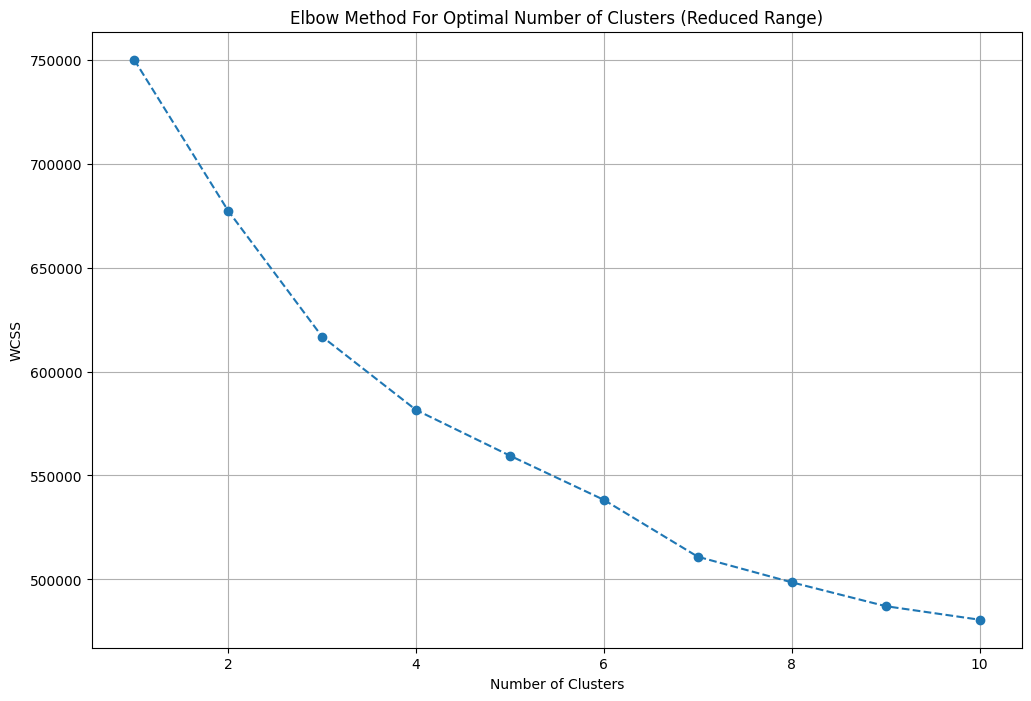

In [61]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [62]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [63]:
cluster_assignments

array([1, 1, 0, ..., 0, 2, 2], shape=(50000,), dtype=int32)

## Creating new data frame for checking the accuracy

In [64]:
new_df = df.copy()

In [65]:
new_df.shape

(50000, 37)

In [66]:
new_df.drop(['ip_address_risk_score','device_trust_score','avg_amount_last_24h','otp_success_rate_customer','merchant_historical_fraud_rate','cust_fraud_rate', 'cust_avg_amt', 'amt_deviation',
       'amt_ratio','merchant_fraud_rate',
       'otp_risk', 'combined_risk','txn_count_last_24h', 'avg_amount_last_24h',
       'merchant_diversity_last_7d'],inplace=True,axis=1)

In [67]:
val = len(new_df.columns)-1
val

22

In [68]:
new_df.insert(loc=val,column="risk_state", value=cluster_assignments)

In [69]:
new_df.head()

,transaction_id,customer_id,device_id,merchant_id,transaction_date,transaction_time,amount,payment_method,is_international,merchant_category,device_change_flag,location_change_flag,authentication_method,past_fraud_count_customer,past_disputes_customer,hour_of_day,day_of_week,is_weekend,cust_txn_count,cust_fraud_count,device_count,new_device_flag,risk_state,is_fraud
32419,32420,1000,22554,780,2024-01-01,23:35:00,556.63,UPI,0,Fashion,0,0,3DS,1,4,23,0,0,11,0,11,1,1,0
47075,47076,1000,25426,563,2024-01-01,23:51:00,10158.89,CARD,0,Gaming,1,0,OTP,2,4,23,0,0,11,0,11,1,1,0
46337,46338,1000,21178,598,2024-01-10,19:49:00,15754.57,UPI,0,Grocery,0,1,OTP,2,1,19,2,0,11,0,11,1,0,0
20435,20436,1000,23086,532,2024-01-20,13:00:00,6095.68,CARD,0,Fashion,0,0,NONE,2,0,13,5,1,11,0,11,1,1,0
49782,49783,1000,29249,592,2024-01-23,10:37:00,15324.24,UPI,0,Gaming,0,0,OTP,1,3,10,1,0,11,0,11,1,2,0


In [70]:
new_df['risk_state'].value_counts()

risk_state
0    19289
2    15437
1    15274
Name: count, dtype: int64

In [71]:
df.drop(columns=['transaction_id', 'customer_id', 'device_id', 'merchant_id'],inplace=True,axis=1)
new_df.drop(columns=['transaction_id', 'customer_id', 'device_id', 'merchant_id'],inplace=True,axis=1)


In [72]:
df.shape

(50000, 33)

In [73]:
new_df.shape

(50000, 20)

In [74]:
# new_df.to_csv(r'C:\Users\mabin\Desktop\DataScienceClassNotes\Career247_Capstone_Project\Fraud_Detection_Project\data\raw\cleaned_data_new_df.csv', index=False)

In [75]:
df.to_csv(r'C:\Users\mabin\Desktop\DataScienceClassNotes\Career247_Capstone_Project\Fraud_Detection_Project\data\raw\cleaned_data_v2.csv', index=False)